In [1]:
import pyautogui
import numpy as np
import time
import imageio
from matplotlib import pyplot as plt

offset_x = 3000
offset_y = 300

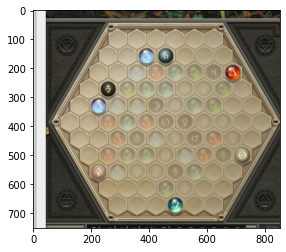

In [2]:
tile_width = 66
tile_height = 57

ox, oy = 276, 85

tiles = []

def get_coord(i, j):
    x = ox + tile_width * j - tile_width//2 * i
    y = oy + tile_height * i
    return offset_x+x+16, offset_y+y+16

def execute_clicks(clicks):
    pyautogui.click(offset_x+100, offset_y)
    time.sleep(1)
    for i, j in clicks:
        x, y = get_coord(i, j)
        pyautogui.moveTo(x=x, y=y)
        pyautogui.mouseDown()
        pyautogui.mouseUp()

def simplify_block(blk):
    r = np.array(np.sum(blk, axis=2))
    r.resize((r.size,))
    d = np.round((r - np.min(r))/(np.max(r) - np.min(r)))
    return d

def get_block(pxl, i, j):
    x = ox + tile_width * j - tile_width//2 * i
    y = oy + tile_height * i
    return pxl[y:y+32, x:x+32, :]

def tiles():
    high = -5
    for i in range(11):
        for j in range(max(0, high), min(11, high + 11)):
            yield i, j
        high += 1
        
def learn(*files):
    mapping = []
    for file in files:
        im = imageio.imread(file+'.png')
        with open(file+".txt") as f:
            correct = [l.strip().upper().split() for l in f]
        for i, j in tiles():
            blk = get_block(im, i, j)
            a = simplify_block(blk)
            mapping.append((correct[i][j], a))
        plt.imshow(im)
    return mapping

mapping = learn("game1", "game2", "game3", "game4")

def parse_board(pxl):
    result = {}
    for i, j in tiles():
        blk = get_block(pxl, i, j)
        a = simplify_block(blk)
        best_fit = min(mapping, key=lambda k: np.linalg.norm(a - k[1]))[0]
        if best_fit  != '__':
            result[(i, j)] = best_fit
    return result


In [3]:
cardinals = ["FI", "WA", "AI", "EA"]
metals = ["M0", "M1", "M2", "M3", "M4", "M5"]

elements = cardinals + metals + ["CH", "HG", "LI", "DE"]

possible_pairings = set(map(tuple, map(sorted, [
    (a, a) for a in cardinals
] + [
    (a, "CH") for a in cardinals
] + [
    (c, "HG") for c in metals[:-1]
] + [
    ("LI", "DE"), ("CH", "CH")
])))

n = [(-1,0),(0,1),(1,1),(1,0),(0,-1),(-1,-1)]

def is_free(board, position):
    e = board[position]
    if e in metals:
        if len(set(board.values()) & set(metals[:metals.index(e)])) > 0:
            return False
    
    i, j = position
    for k in range(6):
        if all((i + n[k-l][0], j + n[k-l][1]) not in board for l in range(3)):
            return True
    return False

def pairings(board):
    l = []
    free = [(p,v) for p, v in board.items() if is_free(board, p)]
    for (pa, a) in free:
        for (pb, b) in free:
            if pb == pa:
                break
            if (a, b) in possible_pairings or (b, a) in possible_pairings:
                l.append((pa, pb))
    if (5,5) in board and is_free(board, (5,5)):
        l.append(((5,5),))
    return l

def count_elements(board):
    counts = {i: 0 for i in elements}
    for v in board.values():
        counts[v] += 1
    return counts
    

def has_hope(board):
    counts = count_elements(board)
    odds = 0
    for c in cardinals:
        if counts[c] % 2 == 1:
            odds += 1
    if odds > counts["CH"]:
        return False
    
    return True

def solve(board, steps):
    if not has_hope(board):
        return
    if len(board) == 0:
        yield list(steps)
    else:
        for p in pairings(board):
            v = tuple(map(board.get, p))
            for i in p:
                del board[i]
            
            steps.append(p)
            yield from solve(board, steps)
            steps.pop()
            
            for i, u in zip(p, v):
                board[i] = u

{'FI': 8,
 'WA': 8,
 'AI': 8,
 'EA': 8,
 'M0': 1,
 'M1': 1,
 'M2': 1,
 'M3': 1,
 'M4': 1,
 'M5': 1,
 'CH': 4,
 'HG': 5,
 'LI': 4,
 'DE': 4}

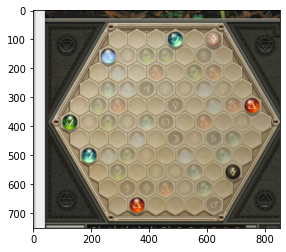

In [15]:
s = pyautogui.screenshot(region=(offset_x,offset_y,850,750))
pxl_data = np.array(s.getdata())
pxl_data.resize((750, 850, 3))

plt.imshow(pxl_data)

board = parse_board(pxl_data)
count_elements(board)

In [16]:
solution = next(solve(board, []))

In [17]:
execute_clicks([c for r in solution for c in r])

In [49]:
solution

[((4, 1), (1, 2)),
 ((5, 2), (2, 7)),
 ((7, 10), (2, 2)),
 ((6, 9), (1, 3)),
 ((5, 8), (3, 1)),
 ((3, 7), (3, 2)),
 ((8, 3), (7, 9)),
 ((6, 8), (2, 3)),
 ((3, 3), (2, 4)),
 ((4, 7), (2, 5)),
 ((7, 8), (7, 3)),
 ((8, 4), (4, 2)),
 ((8, 5), (2, 6)),
 ((8, 8), (3, 4)),
 ((6, 3), (3, 5)),
 ((5, 3), (10, 8)),
 ((7, 4), (9, 7)),
 ((9, 8), (6, 4)),
 ((5, 7), (8, 7)),
 ((4, 3), (7, 7)),
 ((6, 7), (3, 6)),
 ((7, 5), (4, 6)),
 ((4, 5), (5, 4)),
 ((8, 6), (5, 6)),
 ((7, 6), (6, 5)),
 ((6, 6), (4, 4)),
 ((5, 5),)]

UnboundLocalError: local variable 'x' referenced before assignment